In [2]:
import numpy as np
import pandas as pd

from functools import reduce
from datetime import datetime
from itertools import chain
from collections import defaultdict
from matplotlib_venn import venn3
import venn


In [3]:
def join_conjunto_sets2(conjuntos, muertes):
    aux = []
    nuevo_conjunto = []
    siguiente_conjunto = 1
    tiempo = datetime.now()
    
    for A in conjuntos[:-1]:
        for B in conjuntos[siguiente_conjunto:]:
            if A - {max(A)} == B - {max(B)}:
                posible = A.union(B)
                muere = False
                aux.append(posible)
                for muerte in muertes:
                    if muerte.issubset(posible):
                        muere = True
                        break
                if not muere:
                    nuevo_conjunto.append(posible)
            else:
                continue

        siguiente_conjunto += 1    
    
    return nuevo_conjunto

In [4]:
def conjuntos_sobre_umbral_sets(cancion_esta_en, conjuntos, frec_min):
    
    sobrevivientes = []
    muertes = []
    
    diccionario = defaultdict(int)
    aux_cancion_esta_en = defaultdict(set)

    for conjunto in conjuntos:
        setlist = []
        canciones = []
        
        for cancion in conjunto:
            setlist.append(cancion_esta_en[cancion])
            canciones.append(cancion)
        
        repeticiones = len(set.intersection(*setlist))
        if repeticiones >= frec_min:
            sobrevivientes.append((conjunto, repeticiones))
        else:
            muertes.append(conjunto)
    #print(sobrevivientes)

    return sobrevivientes, muertes

In [5]:
def fit(frec_min, datos='spotify.npy'):
    
    data = np.load(datos)
    #listas_datos = [set(x) for x in dict(data.item()).values()]
    
    listas_datos = {x[0]: set(x[1]) for x in dict(data.item()).items()}
    
    frec_min = frec_min * len(listas_datos)
    
    
    canciones = [x for songs in listas_datos.values() for x in songs]
    orden = list(set(canciones))

    enumeracion_canciones = dict(enumerate(orden))  # {0: cancion1, 1: cancion2}...
    canciones_enumeracion = {x[1]: x[0] for x in enumeracion_canciones.items()}  # {cancion1: 0, cancion2: 1... }
       
    playlist = {dato[0]: sorted([canciones_enumeracion[x] for x in dato[1]]) for dato in listas_datos.items()}



    '''####################
    
    data = {'0':['1', '2', '5'], '1':['2', '4'], '2':['2', '3'], '3':['1', '2', '4'], '4':['1', '3'], '4':['2', '3'], 
                                     '6':['1', '3'], '7':['1', '2','3', '5'], '8':['1', '2', '3']}
    #print(data)
    listas_datos = {x[0]: set(x[1]) for x in data.items()}
    # {0: {1, 2, 5}, 1: {2, 4}, 2: {2, 3}, 3: {1, 2, 4}, 4: {1, 3}, 5: {2, 3}, 6: {1, 3}, 7: {1, 2, 3, 5}, 8: {1, 2, 3}}
    frec_min = frec_min * len(listas_datos)

    canciones = [x for songs in listas_datos.values() for x in songs]
    orden = list(set(canciones))
    
    enumeracion_canciones = dict(enumerate(orden))  # {0: cancion1, 1: cancion2}...
    canciones_enumeracion = {x[1]: x[0] for x in enumeracion_canciones.items()}  # {cancion1: 0, cancion2: 1... }
        
    playlist = {dato[0]: sorted([canciones_enumeracion[x] for x in dato[1]]) for dato in listas_datos.items()}

    conjuntos = [{x} for x in canciones_enumeracion.values()]
    
    ####################'''
    

    # seleccionar elementos sobre el umbral  
    
    diccionario = defaultdict(int)
    total = chain(*playlist.values())
    

    t = datetime.now()
    for x in total:
        diccionario[x] += 1

    #print('diccionario frec tardo {} seg\n'.format((datetime.now() - t).total_seconds()))

    conjuntos = [{x[0]} for x in (filter(lambda x: x[1] >= frec_min, diccionario.items()))]
    t = datetime.now()
    
    # seleccionar listas que posean elementos de interés
    #tuplas = []
    #diccionario_playlists = defaultdict(list) # {lista: [canciones]}
    cancion_esta_en = defaultdict(set) # {(canciones): [listas]}
    for indice, lista  in playlist.items():
        for conjunto in conjuntos:
            if conjunto.issubset(lista):
                #diccionario_playlists[indice].append(*conjunto)
                cancion_esta_en[min(conjunto)].add(indice)
                #tuplas.append(lista)

    retorno = []
    k = 2
    #print('diccionario frec tardo {} seg\n'.format((datetime.now() - t).total_seconds()))
    
    
    muerte = []
    listas = conjuntos
    aux = []
    for conjunto in listas:
        l = set()
        l.add(enumeracion_canciones[min(conjunto)])
        aux.append((l, len(cancion_esta_en[min(conjunto)])))

    retorno.extend(aux)

    while True: 
        t = datetime.now()
        
        conjuntos = join_conjunto_sets2(listas, muerte)
        #print('{}: join tardo {} seg'.format(k, (datetime.now() - t).total_seconds()))
        listas, muerte = conjuntos_sobre_umbral_sets(cancion_esta_en, conjuntos, frec_min)

        repeticiones = [x[1] for x in listas]
        listas = [x[0] for x in listas]
        t = datetime.now()
        #print('{}: conjuntos sobre umbral tardo {} seg\n'.format(k, (datetime.now() - t).total_seconds()))

        if not listas:  
            return retorno
        
        else:
            aux = []
            for conjunto in range(len(listas)):
                l = set()
                for dato in listas[conjunto]:
                    l.add((enumeracion_canciones[dato]))
                aux.append((l, repeticiones[conjunto]))

            retorno.extend(aux)

In [6]:
t = 0
tiempo = datetime.now()
a = fit(0.02)

t += (datetime.now() - tiempo).total_seconds()
print('tiempo:', t)

tiempo: 3.267268


In [7]:
for x in a:
    print(x)

({'Mr. Brightside'}, 248)
({'Party In The U.S.A.'}, 211)
({'Forever'}, 321)
({'Hey Ya! - Radio Mix / Club Mix'}, 203)
({"It Wasn't Me"}, 218)
({'Yeah!'}, 238)
({'Closer'}, 723)
({'Say My Name'}, 266)
({'Home'}, 454)
({'Ignition - Remix'}, 310)
({'Bohemian Rhapsody - Remastered 2011'}, 240)
({'No Role Modelz'}, 311)
({'Stronger'}, 258)
({"Don't Stop Believin'"}, 261)
({'Lean On (feat. MØ & DJ Snake)'}, 265)
({'Riptide'}, 332)
({'Trouble'}, 216)
({'All I Want'}, 221)
({'Mercy'}, 305)
({'Intro'}, 215)
({'Gravity'}, 200)
({'Sober'}, 247)
({'One Dance'}, 411)
({'My Girl'}, 286)
({'Redbone'}, 281)
({'Body Like A Back Road'}, 267)
({'Crazy'}, 208)
({'Sweet Home Alabama'}, 207)
({"Sweet Child O' Mine"}, 205)
({'Despacito - Remix'}, 282)
({"I'm the One"}, 319)
({'Hello'}, 289)
({'Jungle'}, 220)
({'Uptown Funk'}, 231)
({'V. 3005'}, 221)
({'CAN\'T STOP THE FEELING! (Original Song from DreamWorks Animation\'s "TROLLS")'}, 205)
({'Angel'}, 218)
({'Hold On'}, 225)
({'Waves'}, 242)
({'Black Beatles'}

In [8]:
def fconfianza(subconjunto, conjunto, n):
    sub = 0
    conj = 0
    for lista in listas:
        if subconjunto.issubset(lista):
            sub += 1
        if conjunto.issubset(lista):
            conj += 1
    return con / sub
        
            

def fsoporte(conjunto, listas):
    conj = 0
    n = 0
    for lista in listas:
        if conjunto.issubset(lista):
            conj += 1
        n += 1
    return conj / n


def subsets(conjunto):
    retorno = []
    listas = list(conjunto)

    def backtrack(i=0):            
        if i == len(listas):
            yield set(retorno)
            
        
        else:
            yield from backtrack(i + 1)
            retorno.append(listas[i])
            
            yield from backtrack(i + 1)
            retorno.pop()

    yield from backtrack()
    
    
    
def generate(frecuentes, n):        
    table = []
    datos = []
    encabezado = ['conjunto', 'subconjunto', 'confianza', 'soporte', 'lift']
    conj_repetidos = []
    sub_repetidos = []


    for conjunto in sorted(frecuentes, key=lambda x: len(x[0])):
        if len(conjunto[0]) == 1:
            if conjunto[0] in conj_repetidos:
                continue
            confianza = 1
            soporte = conjunto[1] / n        
            lift =  confianza / soporte
            table.append(['  |  '.join(list(conjunto[0])), '         ', str(round(confianza, 3)), str(round(soporte, 3)), str(round(lift, 3))])
            datos.append([conjunto[0], confianza, soporte, lift])

        else:
            elementos = conjunto[0] # {'HUMBLE.', 'XO TOUR Llif3'}
            frec = conjunto[1]
            subset = list(subsets(elementos)) # [set(), {'XO TOUR Llif3'}, {'HUMBLE.'}, {'HUMBLE.', 'XO TOUR Llif3'}]
                
            for conjunt in range(len(subset)): # 4
                if subset[conjunt]: # != set()
                    for A in elementos:
                        conj = elementos - {A}
                        sub = {A}
                        if conj in conj_repetidos and sub in sub_repetidos:
                            continue

                        conj_repetidos.append(conj)
                        sub_repetidos.append(sub)
                        if conj:
                            frec_conj = 0
                            frec_sub = 0
                            for x in frecuentes:
                                if x[0] == sub:
                                    frec_sub = x[1]
                                    print(x[0], x[1])
                                if x[0] == conj:
                                    frec_conj = x[1]
                                    print(x[0], x[1])
                            
                            print('conj', conj)
                            print('sop', sub)
                            confianza = conjunto[1] / frec_sub 
                            soporte = conjunto[1] / n
                            print(confianza, soporte )
                            print()
                            lift =  confianza / soporte
                            datos.append([conj, sub, confianza, soporte, lift])
                            #print(str(round(confianza, 3)), str(round(soporte, 5)), str(round(lift, 3)))
                            table.append(['  |  '.join(list(conj)), '   |  '.join(list(sub)), str(round(confianza, 3)), str(round(soporte, 5)), str(round(lift, 3))])

    with open('resultado.csv', 'w') as resultados:
        df =  pd.DataFrame(sorted(table, key=lambda x: x[3], reverse=True), columns=encabezado)
        resultados.write(df.to_string(index=False))

            
    return datos
data = np.load('spotify.npy')  
listas_datos = [x for x in dict(data.item()).items()]
    
datos = generate(a, len(listas_datos))


{'XO TOUR Llif3'} 323
{'HUMBLE.'} 465
conj {'XO TOUR Llif3'}
sop {'HUMBLE.'}
0.43870967741935485 0.0204

{'XO TOUR Llif3'} 323
{'HUMBLE.'} 465
conj {'HUMBLE.'}
sop {'XO TOUR Llif3'}
0.631578947368421 0.0204

{'Congratulations'} 403
{'HUMBLE.'} 465
conj {'Congratulations'}
sop {'HUMBLE.'}
0.46021505376344085 0.0214

{'Congratulations'} 403
{'HUMBLE.'} 465
conj {'HUMBLE.'}
sop {'Congratulations'}
0.5310173697270472 0.0214

{'HUMBLE.'} 465
{'Mask Off'} 316
conj {'Mask Off'}
sop {'HUMBLE.'}
0.43870967741935485 0.0204

{'HUMBLE.'} 465
{'Mask Off'} 316
conj {'HUMBLE.'}
sop {'Mask Off'}
0.6455696202531646 0.0204



In [9]:
def ranking(datos):
    # filtro 1: más de 1 item en el itemset
    itemsets = [x for x in datos if len(x) > 4]
    if not itemsets:
        return sorted([x for x in datos if x[-2] > 0.7 and x[-3] > 0.02], key=lambda x: x[-1], reverse=True)[:10]
    

    confianzas = sorted([x[-3] for x in itemsets])
    soportes = sorted([x[-2] for x in itemsets])    
    lift = sorted([x[-1] for x in itemsets])

    prom_conf = sum(confianzas) / len(confianzas)
    prom_sop = sum(soportes) / len(soportes)

    confianza_min = max((prom_conf + max(confianzas)) / 2, confianzas[round(0.75 * len(confianzas))])
    soporte_min = max((prom_sop + max(soportes)) / 2, soportes[round(0.75 * len(soportes))])
    
    n = 0
    iteracion = 0
    while n < 10 and n != len(itemsets): 
        if iteracion:
            confianza_min = confianza_min * 0.95
            soporte_min = soporte_min * 0.9
            
        # filtro 1:  conf > 0.9
        itemset_sobre_conf = [x for x in itemsets if x[-3] > confianza_min]

        # filtro 2: soporte > 0.012
        itemset_sobre_sop = [x for x in itemset_sobre_conf if x[-2] > soporte_min]

        # ordenar por lift 
        top_10 = sorted(itemset_sobre_sop, key=lambda x: x[-1], reverse=True)[:10]
        
        n = len(top_10)
        iteracion += 1
    
    table = []
    encabezado = ['conjunto', 'subconjunto', 'confianza', 'soporte', 'lift']

    for x in top_10:
        table.append(['  |  '.join(list(x[0])), '   |  '.join(list(x[1])), str(round(x[2], 3)), str(round(x[3], 5)), str(round(x[4], 3))])

    with open('top.csv', 'w') as resultados:
        df =  pd.DataFrame(table, columns=encabezado)
        resultados.write(df.to_string(index=False))
        print(df)
    
    return top_10
        
rank = ranking(datos)


          conjunto      subconjunto confianza soporte    lift
0          HUMBLE.         Mask Off     0.646  0.0204  31.646
1          HUMBLE.    XO TOUR Llif3     0.632  0.0204   30.96
2          HUMBLE.  Congratulations     0.531  0.0214  24.814
3  Congratulations          HUMBLE.      0.46  0.0214  21.505
4    XO TOUR Llif3          HUMBLE.     0.439  0.0204  21.505
5         Mask Off          HUMBLE.     0.439  0.0204  21.505


In [10]:
for x in rank:
    print(x)

apariciones = [round(x[3] * 10000) for x in rank]
print(apariciones)

[{'HUMBLE.'}, {'Mask Off'}, 0.6455696202531646, 0.0204, 31.645569620253163]
[{'HUMBLE.'}, {'XO TOUR Llif3'}, 0.631578947368421, 0.0204, 30.95975232198142]
[{'HUMBLE.'}, {'Congratulations'}, 0.5310173697270472, 0.0214, 24.81389578163772]
[{'Congratulations'}, {'HUMBLE.'}, 0.46021505376344085, 0.0214, 21.505376344086024]
[{'XO TOUR Llif3'}, {'HUMBLE.'}, 0.43870967741935485, 0.0204, 21.50537634408602]
[{'Mask Off'}, {'HUMBLE.'}, 0.43870967741935485, 0.0204, 21.50537634408602]
[204, 204, 214, 214, 204, 204]


defaultdict(<class 'list'>, {'HUMBLE.': [0, 1, 2, 3, 4, 5], 'Mask Off': [0, 5], 'XO TOUR Llif3': [1, 4], 'Congratulations': [2, 3]})
<class 'set'>


IndexError: list index out of range

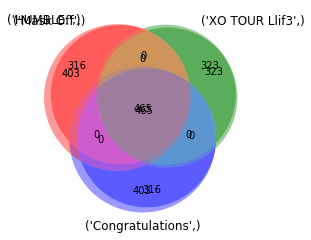

In [23]:
def representar_confiaza(datos):
    data = 10000
    total = {*range(data)}
    
    aux = [round(x[3] * 10000) for x in datos]

    apariciones_conjunto = {tuple(list(x[0].union(x[1]))): round(x[3] * data) for x in datos}
    
    apariciones_subconjunto = {tuple(list(rank[x][1])): round(aux[x] / datos[x][2])for x in range(len(datos))}
    
    '''print(apariciones_conjunto)
    print()
    print(apariciones_subconjunto)
    print()'''
    
    apariciones_subconjunto
    #print(rank == datos)
    sets = list(tuple([*x[0].union(x[1])]) for x in datos)
    
    dic_apariciones = defaultdict(list)

    for x in range(len(sets)):
        for dato in sets[x]:
            dic_apariciones[dato].append(x)
    
   
    n = 0
    lista_set = [set() for x in sets]
    
    print(dic_apariciones)

    n = 0
    frec = 0
    orden = []
    for item in apariciones_subconjunto.items():
        frec += item[1]
        orden.append(item[0])
        while n < frec:
            for x in dic_apariciones[list(item)[0][0]]:
                if n < frec:
                    lista_set[x].add(n)
                else:
                    break
            n += 1  
        
            
    #print(dic_apariciones)
    largo = len(lista_set)
    print(type(lista_set[0]))
    
    venn3(lista_set[:3] , orden[:3])
    venn3(lista_set[3:],orden[3:])
    
    plt.show()
    

representar_confiaza(rank)
    

In [146]:
a = {1,2,3,4,5}
b = {1,2,3,4}
c = {3,4,5,8}
{1:3 for x in range(4)}

{1: 3}

In [33]:
conjunto = {'A', 'B', 'C', 'D'}

def subsets(conjunto, retorno=[]):
    retorno = []
    aux_conjunto = conjunto
    
    for A in list(conjunto):
        #print(conjunto, A)
        nuevo_conjunto = conjunto - {A}
        #print('nuevo:',nuevo_conjunto)
        #agregar = True
        
        #for conjunto in retorno:
            #print(conjunto, '==', nuevo_conjunto, conjunto == nuevo_conjunto )
         #   if conjunto == nuevo_conjunto:
          #      agregar = False
           #     break
                
        #if agregar:
        agregar = True
        if nuevo_conjunto:
            for x in retorno:
                #print(x,'==', nuevo_conjunto, x == nuevo_conjunto)
                if x == nuevo_conjunto:
                    agregar = False
            if agregar:
                retorno.append(conjunto - {A})
            #subset2 = subsets(conjunto - {A}, retorno)
            #print(retorno)

            #if subset2:
             #   retorno.extend(subset2)
    for x in retorno.copy():
        retorno.extend(subsets(x, retorno))
    return retorno
    #print()

